<a href="https://colab.research.google.com/github/Herdvair/A-B-Testing-DIgital-Marketing/blob/main/A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os

pd.options.display.max_columns = 999
pd.options.display.float_format = "{:.2f}".format

In [ ]:
df = pd.read_csv('marketing_AB.csv')

df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


**Data Description**

- user id : id pengguna secara unik
- test group : jika "ads" maka user tersebut melihat iklan, jika "psa" maka user melihat pengumuman layanan masyarakat
- converted : "True" jika user membeli produk, "False" jika tidak
- total ads : jumlah iklan yang dilihat oleh user
- most ads days : hari dimana user tersebut melihat jumlah iklan terbanyak
- most ads hour : jam dalam sehari dimana user melihat jumlah iklan terbanyak

In [ ]:
df_market = df.copy(deep=True)

# Data Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [ ]:
len(df_market.drop_duplicates())/len(df_market)

1.0

In [ ]:
df_market.isna().sum()

,0
Unnamed: 0,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


In [ ]:
df_market.isnull().sum()

,0
Unnamed: 0,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


In [ ]:
features = ['total ads', 'most ads hour']
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew,shapiro

def check_plot(df_market,features):

    for i in features:

    # tentukan ukuran gambar
        plt.figure(figsize=(20, 4))

        # histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df_market[i], bins=30)
        plt.title('Histogram')

    # box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df_market[i])
        plt.title('Boxplot')

        plt.show()

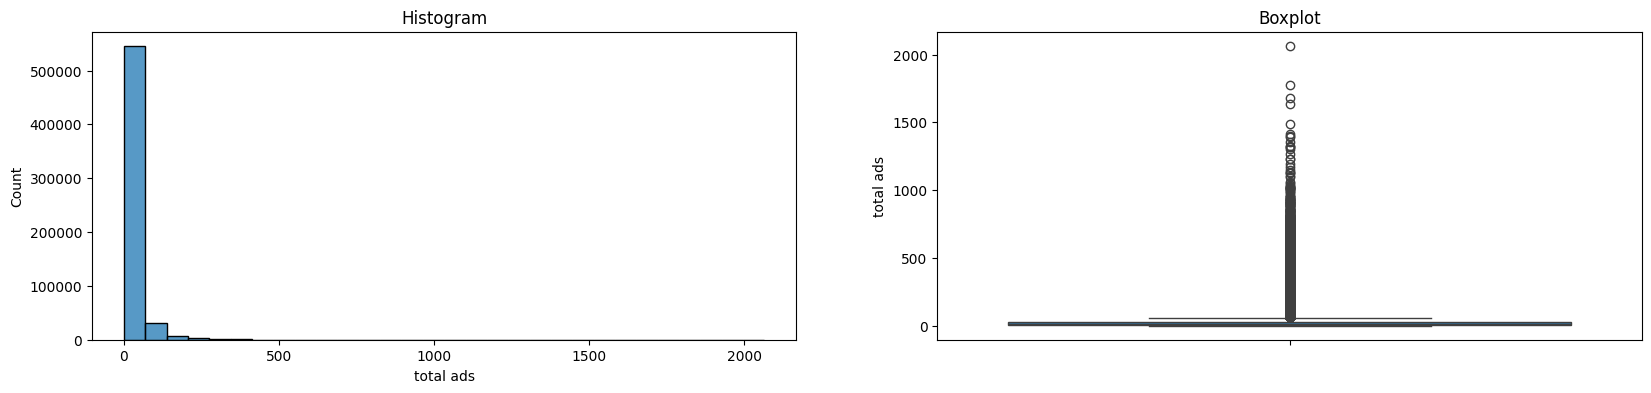

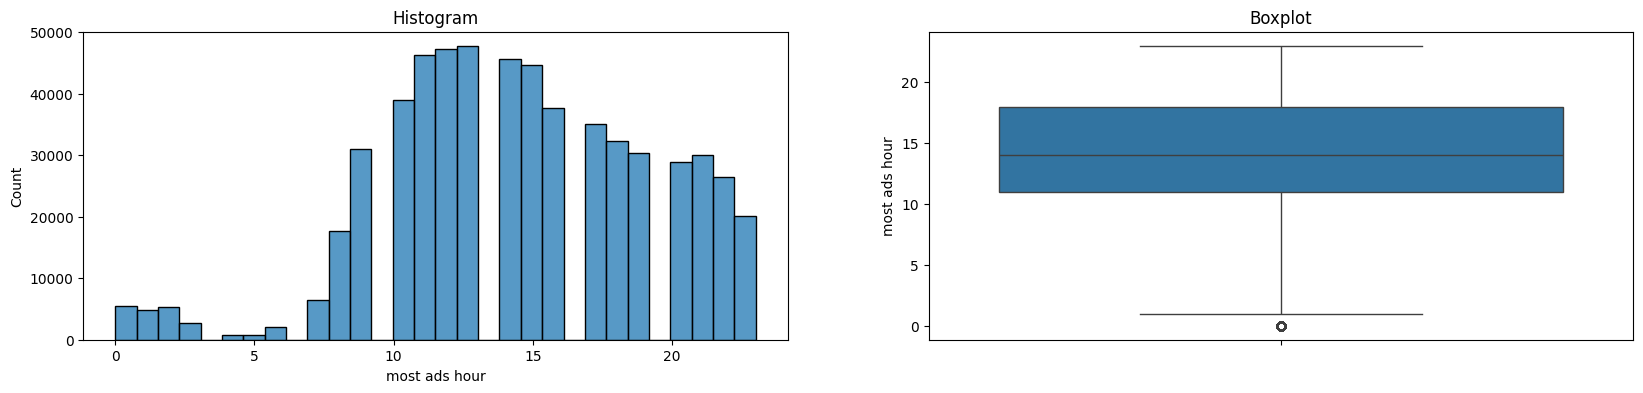

In [ ]:
check_plot(df_market,features)

In [ ]:
df_market.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.00,588101.00,588101.00,588101.00
mean,294050.00,1310692.22,24.82,14.47
std,169770.28,202225.98,43.72,4.83
min,0.00,900000.00,1.00,0.00
25%,147025.00,1143190.00,4.00,11.00
50%,294050.00,1313725.00,13.00,14.00
75%,441075.00,1484088.00,27.00,18.00
max,588100.00,1654483.00,2065.00,23.00


In [ ]:
outlier_count = df_market[df_market['total ads'] > 1000].shape[0]
outlier_count

36

In [ ]:
total_users = df_market.shape[0]
total_users

588101

In [ ]:
outlier_percentage = (outlier_count / total_users) * 100
outlier_percentage

0.006121397515052687

Insight : Dilakukan handling outlier karena nilai maksimum sangat jauh dari median dan mean. Hasil analisis menunjukkan bahwa :
1. nilai maksimum mencapai 2065, sementara median hanya 13 dan mean hanya 24.82
2. dlakukan check persentasi outlier jika total ads > 1000 dan didapat sebanyak 36 user dari 588.101 pengguna.
3. Hal ini mengindikasikan adanya anomali yang ada dalam data total ads
4. oleh karena itu dilakukan handling outlier untuk menjaga kualitas data.

In [ ]:
def find_outlier_boundary(df_market,features):

    IQR = df_market[features].quantile(0.75) - df_market[features].quantile(0.25)

    lower_boundary = df_market[features].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df_market[features].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

In [ ]:
full_occup_upper_limit, full_occup_lower_limit = find_outlier_boundary(df_market, features)
print(f"upper limit : \n{full_occup_upper_limit}")
print(f"lower limit : \n{full_occup_lower_limit}")

upper limit : 
total ads       61.50
most ads hour   28.50
dtype: float64
lower limit : 
total ads       -30.50
most ads hour     0.50
dtype: float64


In [ ]:
df_market = df_market[
        (df_market[features[0]] >= full_occup_lower_limit.iloc[0]) & (df_market[features[0]] <= full_occup_upper_limit.iloc[0])
    ]

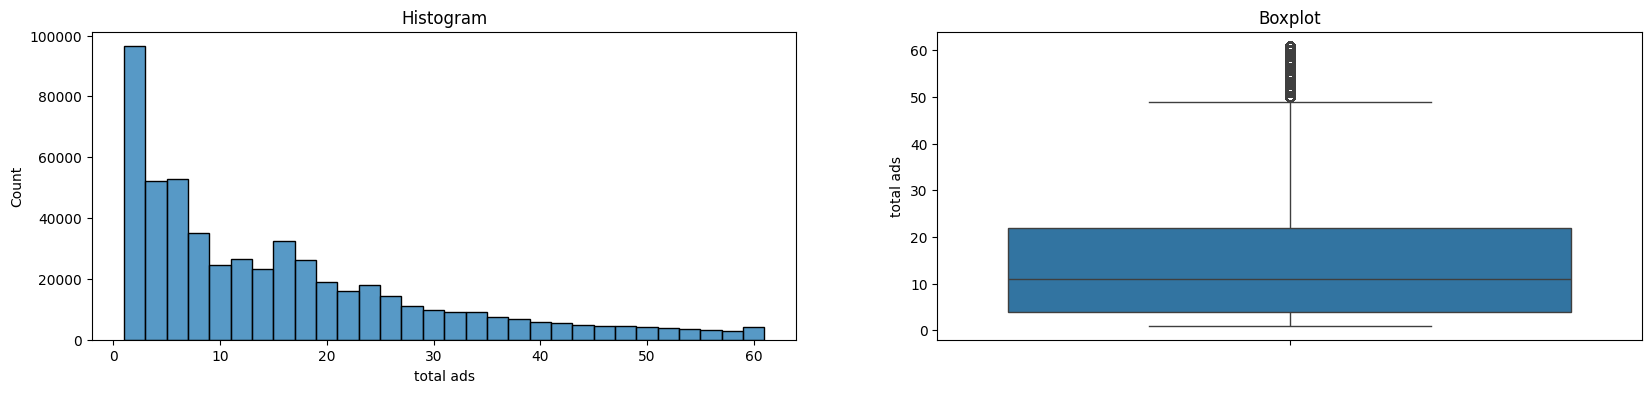

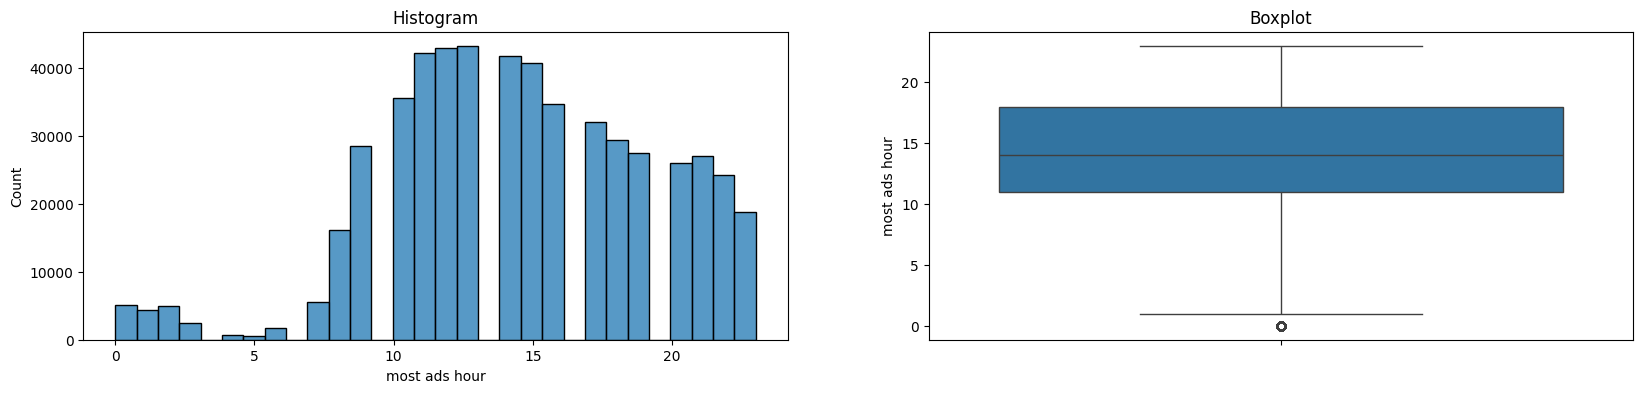

In [ ]:
check_plot(df_market,features)

In [ ]:
df_market.shape

(536044, 7)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Kolom-kolom yang ingin di-label encode -> 0 = false, 1 = True
columns_to_encode = ['converted']

# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

In [ ]:
df_market['converted'] = label_encoder.fit_transform(df_market['converted'])

**Objective Analysis** :

Menganalisis efektivitas penayangan iklan digital terhadap perilaku pengguna dalam melakukan aksi pembelian, serta memastikan tidak ada efek samping yang merugikan dari sisi paparan iklan dan waktu tayang.

## Success Metrics

**Conversion Rate**

Hipotesis :
Jika pengguna diberikan iklan digital (ad), maka mereka lebih aktif dalam membeli produk dibandingkan jika hanya diberikan iklan layanan masyarakat (PSA).

In [ ]:
# Hitung conversion rate secara umum
conversion_rate2= df_market['converted'].mean() * 100
print(f"Conversion rate keseluruhan: {conversion_rate2:.2f}%")

Conversion rate keseluruhan: 1.33%


In [ ]:
# Hitung conversion rate per test group
conversion_rate_per_group2 = df_market.groupby('test group')['converted'].mean() * 100
conversion_rate_per_group2

,converted
test group,
ad,1.34
psa,1.06


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Pisahkan grup kontrol dan grup iklan (test)
group_control2 = df_market[df_market['test group'] == 'psa']
group_ad2 = df_market[df_market['test group'] == 'ad']

# Hitung jumlah pengguna yang converted di tiap grup
conversion2 = [
    group_ad2['converted'].sum(),
    group_control2['converted'].sum()
]

# Hitung total pengguna di tiap grup
sample2 = [
    group_ad2['converted'].shape[0],
    group_control2['converted'].shape[0]
]

In [ ]:
# Uji proporsi: apakah conversion rate grup iklan lebih besar dari kontrol?
z_stat, p_value = proportions_ztest(conversion2, sample2, alternative='larger')

In [ ]:
# Tampilkan hasil
print(f"P-value: {p_value:.4f}")
print(f"CVR control: {(group_control2['converted'].mean() * 100):.2f}%")
print(f"CVR ad: {(group_ad2['converted'].mean() * 100):.2f}%")

if p_value < 0.05:
  print("Reject null hypothesis")
else:
  print("Fail to reject null hypothesis")

P-value: 0.0002
CVR control: 1.06%
CVR ad: 1.34%
Reject null hypothesis


**Insight**

Hasil pengujian menunjukkan bahwa pengguna yang melihat iklan digital (ad group) memiliki conversion rate (CVR) sebesar 1.34%, lebih tinggi dibandingkan dengan pengguna yang hanya melihat iklan layanan masyarakat atau psa (control group) sebesar 1.06%. Uji statistik menghasilkan nilai p-value = 0.0002, yang jauh lebih kecil dari ambang signifikansi 0.05. Artinya, perbedaan tersebut signifikan secara statistik.
Dengan demikian, penayangan iklan digital terbukti secara signifikan meningkatkan aksi pembelian pengguna dibandingkan iklan layanan masyarakat. Oleh karena itu, strategi kampanye berbasis iklan layak diteruskan.

## Guardrail Metrics

### Users ads

Hipotesis :

Apakah ada perbedaan signifikan rata-rata jumlah iklan yang dilihat user pada grup ad vs psa?

In [ ]:
# Pisahkan grup kontrol dan grup iklan (test)
group_control2 = df[df['test group'] == 'psa']
group_ad2 = df[df['test group'] == 'ad']

# Hitung jumlah pengguna
total_ads_sum2 = [
    group_ad2['total ads'].sum(),
    group_control2['total ads'].sum()
]

# Hitung jumlah pengguna per grup
user_counts2 = [
    group_ad2.shape[0],
    group_control2.shape[0]
]

In [ ]:
# Hitung rata-rata total ads per user per grup
avg_ads_ad2 = total_ads_sum2[0] / user_counts2[0]
avg_ads_control2 = total_ads_sum2[1] / user_counts2[1]

print(f"Rata-rata total ads per user (ad): {avg_ads_ad2:.2f}")
print(f"Rata-rata total ads per user (control): {avg_ads_control2:.2f}")

Rata-rata total ads per user (ad): 24.82
Rata-rata total ads per user (control): 24.76


In [ ]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(group_ad2['total ads'], group_control2['total ads'], alternative='two-sided')
print(f"P-value: {p:.4f}")
print(f"Mean total ads per user (ad group): {group_ad2['total ads'].mean():.2f}%")
print(f"Mean total ads per user (control group): {group_control2['total ads'].mean():.2f}%")

P-value: 0.0000
Mean total ads per user (ad group): 24.82%
Mean total ads per user (control group): 24.76%


**Insight**

Hasil pengujian menunjukkan bahwa rata-rata jumlah iklan yang dilihat oleh user group ads lebih tinggi yaitu 24.82% dibandingkan user group psa (user group control) yaitu 24.76. Meskipun selisihnya tidak jauh beda. Namun uji statistik menghasilkan nilai p-value = 0.0000, yang sangat jauh dari ambang signifikansi 0.05. Ini berarti perbedaan tersebut signifikan secara statistik.Hal ini menunjukkan bahwa sistem penayangan iklan bekerja secara berbeda antar grup, namun tidak menyebabkan lonjakan paparan yang ekstrem pada grup eksperimen, sehingga masih aman dari risiko overexposure.

### Most ads day

Hipotesis :

Apakah distribusi jumlah iklan per hari berbeda signifikan antara grup ad dan psa?

In [ ]:
group_ad2 = df[df['test group'] == 'ad']
group_control2 = df[df['test group'] == 'psa']

<Figure size 1200x500 with 0 Axes>

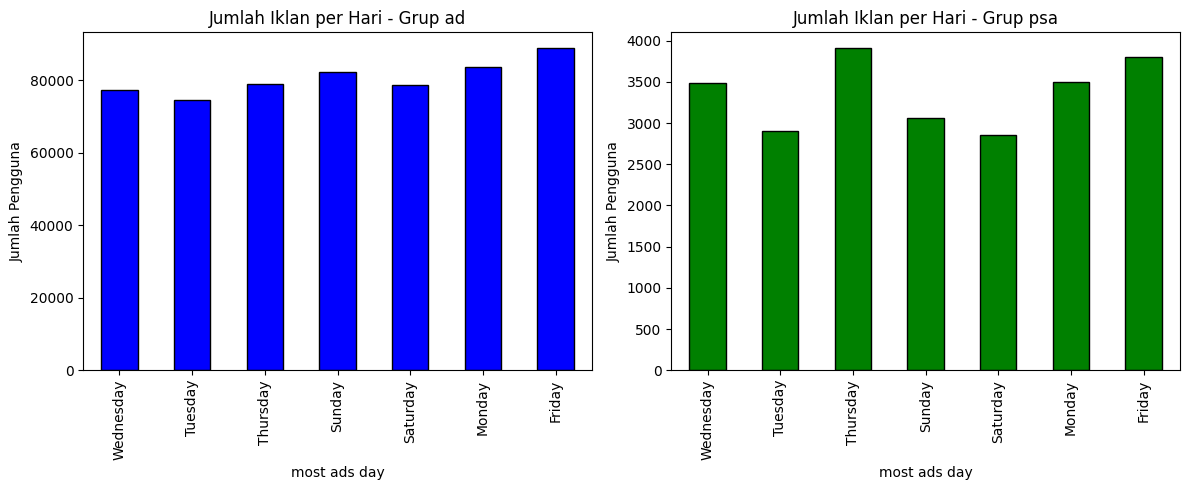

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Hitung frekuensi most_ads_day untuk masing-masing grup
dist_ad = group_ad2['most ads day'].value_counts().sort_index(ascending=False)
dist_psa = group_control2['most ads day'].value_counts().sort_index(ascending=False)

# Plot sebagai bar chart
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
dist_ad.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Jumlah Iklan per Hari - Grup ad')
plt.ylabel('Jumlah Pengguna')

plt.subplot(1, 2, 2)
dist_psa.plot(kind='bar', color='green', edgecolor='black')
plt.title('Jumlah Iklan per Hari - Grup psa')
plt.ylabel('Jumlah Pengguna')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

data = pd.crosstab(df_market['most ads day'], df_market['test group'])

stat, p, dof, expected = chi2_contingency(data)

In [ ]:
print(f"P-value: {p:.4f}")
if p <= 0.05:
  print("Reject null hypothesis")
else:
  print("Fail to reject null hypothesis")

P-value: 0.0000
Reject null hypothesis


**insight**

hasil uji statistik menunjukkan p-value = 0.0000 artinya bahwa ada perbedaan secara signifikan pada distribusi ini. Pola penyebaran iklan antara kedua grup berbeda secara nyata. Grup ad menunjukkan distribusi yang lebih seimbang, sedangkan grup psa (group control) cenderung tidak merata. Hal ini bisa berdampak pada efektivitas penayangan dan persepsi pengguna terhadap iklan di hari-hari tertentu.

- **Type of experiment** : Superiority Test -> menguji apakah grup ad lebih efisien daripada grup psa (control)
- **Find the right sample**
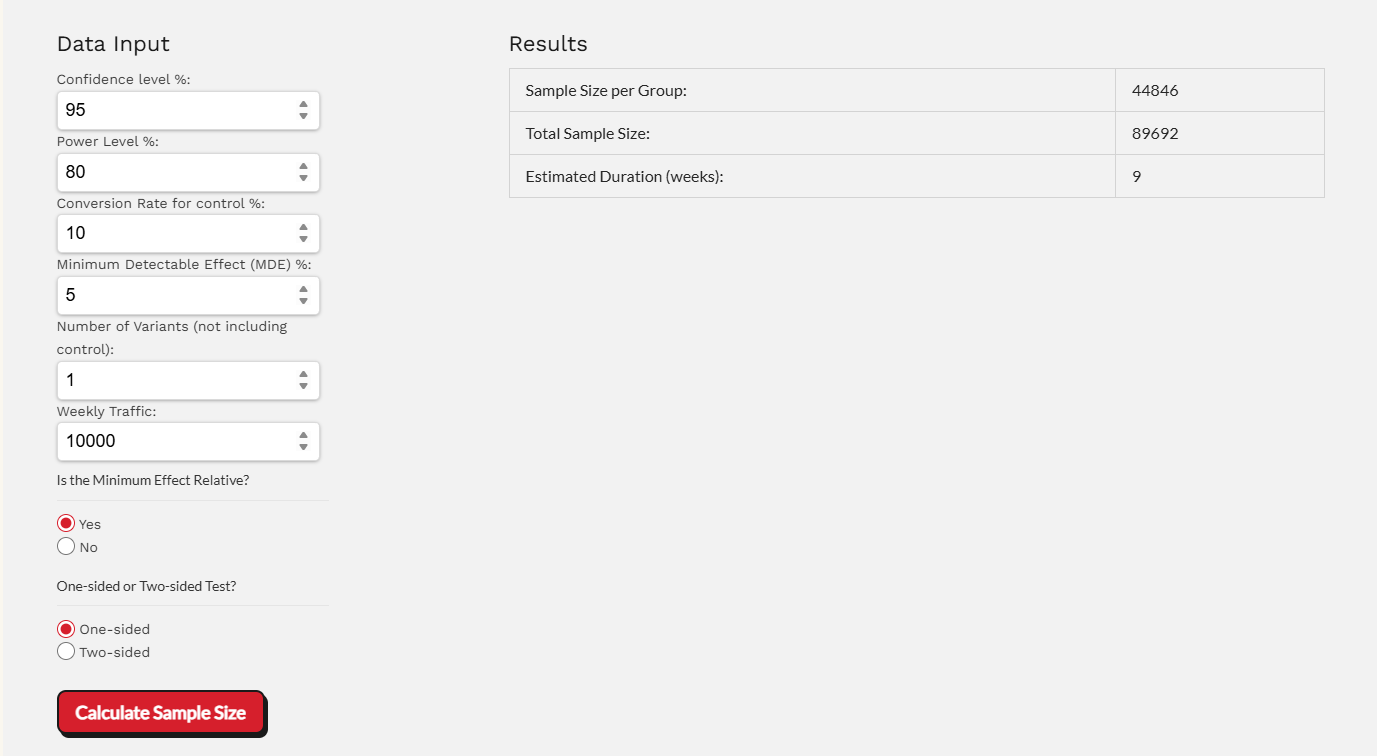



- Eligible users : semua user yang memenuhi syarat yang valid (tanpa adanya missing)
- Durasi eksperimen : Disarankan selama 9 minggu untuk mencakup variasi hari dan ukuran sampel yang tersedia 588,101 user.